# 1.


In [48]:
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 讀xml檔案

In [49]:
def loaddata(file_path):
  tree = ET.parse(file_path)
  root = tree.getroot()
  namespace = {'cwa': root.tag.split('}')[0][1:]}
  geo_info_node = root.find('./cwa:dataset/cwa:GeoInfo', namespace)
  start_lon_str = geo_info_node.find('cwa:BottomLeftLongitude', namespace).text
  start_lat_str = geo_info_node.find('cwa:BottomLeftLatitude', namespace).text
  start_lon = float(start_lon_str)
  start_lat = float(start_lat_str)
  content_node = root.find('./cwa:dataset/cwa:Resource/cwa:Content', namespace)
  raw_data_string = content_node.text.strip()
  lines = raw_data_string.splitlines()
  grid_data = []
  for line in lines:
      line_content = line.strip()
      if not line_content: continue
      values_str = line_content.replace('  ', ' ').split(',')
      values = [float(v) for v in values_str if v.strip()]
      if values: grid_data.append(values)
  return grid_data, start_lon, start_lat

## GDA

In [50]:
class GDA:
    def __init__(self):
        self.phi = None
        self.mu_0 = None
        self.mu_1 = None
        self.sigma = None
        self.sigma_inv = None

    def fit(self, X, y):
        n_samples, _ = X.shape
        # 1. 計算類別 1 的先驗機率 φ
        self.phi = np.mean(y == 1)
        # 2. 計算兩個類別的特徵平均值 μ₀, μ₁
        self.mu_0 = np.mean(X[y == 0], axis=0)
        self.mu_1 = np.mean(X[y == 1], axis=0)
        # 3. 計算共享的共變異數矩陣
        n_0, n_1 = np.sum(y == 0), np.sum(y == 1)
        cov_0 = np.cov(X[y == 0].T, bias=True)
        cov_1 = np.cov(X[y == 1].T, bias=True)
        self.sigma = (n_0 * cov_0 + n_1 * cov_1) / n_samples
        self.sigma_inv = np.linalg.inv(self.sigma)

    def predict(self, X):
        term_0 = np.sum((X - self.mu_0) @ self.sigma_inv * (X - self.mu_0), axis=1)
        term_1 = np.sum((X - self.mu_1) @ self.sigma_inv * (X - self.mu_1), axis=1)
        log_posterior_0 = np.log(1 - self.phi) - 0.5 * term_0
        log_posterior_1 = np.log(self.phi) - 0.5 * term_1
        return (log_posterior_1 > log_posterior_0).astype(int)

## 繪圖

In [51]:
def plot_gda_decision_boundary(X, y, model, title):
    plt.figure(figsize=(12, 9))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='royalblue', alpha=0.5, label='label 0 ')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='tomato', alpha=0.5, label='label 1 ')

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.xlabel(' (Longitude)'); plt.ylabel(' (Latitude)')
    plt.title(title, fontsize=16); plt.legend(); plt.grid(True); plt.show()


In [54]:
file_path = '/content/O-A0038-003.xml'
grid_data, start_lon, start_lat = loaddata(file_path)

# 準備分類資料
all_classification_points = []
resolution = 0.03
for r_idx, row in enumerate(grid_data):
    for c_idx, temp_c in enumerate(row):
        lon = start_lon + c_idx * resolution
        lat = start_lat + r_idx * resolution
        label = 0 if temp_c == -999.0 else 1
        all_classification_points.append([lon, lat, label])

classification_data_np = np.array(all_classification_points)
X_class, y_class = classification_data_np[:, :2], classification_data_np[:, 2]

# 分割訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=123)
print(f"訓練集大小: {len(X_train)}, 測試集大小: {len(X_test)}")

# 訓練並評估 GDA 模型
gda_model_for_eval = GDA()
gda_model_for_eval.fit(X_train, y_train)
y_pred = gda_model_for_eval.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nGDA 模型在測試集上的準確率: {accuracy * 100:.2f}%")

訓練集大小: 6432, 測試集大小: 1608

GDA 模型在測試集上的準確率: 51.43%


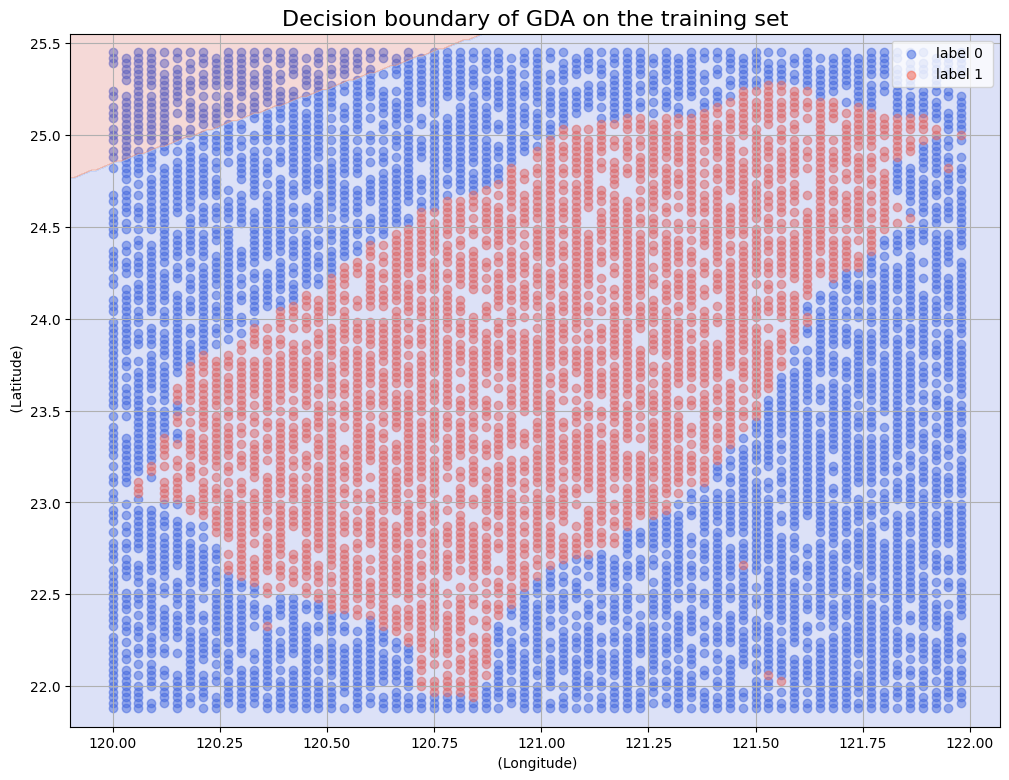

In [56]:
# 視覺化決策邊界
plot_gda_decision_boundary(X_train, y_train, gda_model_for_eval, 'Decision boundary of GDA on the training set')

# 2.

## Regression資料準備

In [80]:
def regression_dataset(grid_data, start_lon, start_lat):
    resolution = 0.03
    regression_data = []
    for row_idx, row_values in enumerate(grid_data):
        for col_idx, celsius_temp in enumerate(row_values):
            if celsius_temp != -999.0:
                current_lat = start_lat + row_idx * resolution
                current_lon = start_lon + col_idx * resolution
                fahrenheit_temp = (celsius_temp * 9/5) + 32
                regression_data.append((current_lon, current_lat, fahrenheit_temp))
    return regression_data

## 定義 R(x) 模型

In [81]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(2, 1) # 2個輸入 (lon, lat), 1個輸出 (temp)

    def forward(self, x):
        return self.linear(x)

In [82]:
def train_regression_model(model, loader, epochs=200, lr=0.001):
    criterion = nn.MSELoss() # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for features, labels in loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

## 組合模型 h(x)

In [83]:
class PiecewiseRegressionModel:
    def __init__(self, classification_model, regression_model, feature_mu, feature_sigma, label_mu, label_sigma):
        self.C = classification_model
        self.R = regression_model
        self.feature_mu = feature_mu
        self.feature_sigma = feature_sigma
        self.label_mu = label_mu
        self.label_sigma = label_sigma
        self.R.eval()

    def predict(self, X):
        # 1. 使用分類模型 C(x) 進行預測
        class_preds = self.C.predict(X)
        # 2. 使用迴歸模型 R(x) 進行預測
        X_tensor = torch.tensor(X, dtype=torch.float32)
        X_scaled = (X_tensor - self.feature_mu) / self.feature_sigma # 標準化輸入
        with torch.no_grad():
            temp_preds_scaled = self.R(X_scaled)

        # 反標準化，還原成原始溫度尺度
        temp_preds = (temp_preds_scaled * self.label_sigma + self.label_mu).numpy().flatten()
        # 3. 根據分類結果組合輸出
        final_preds = np.full(X.shape[0], -999.0)
        valid_indices = (class_preds == 1)
        final_preds[valid_indices] = temp_preds[valid_indices]
        return final_preds

In [84]:

gda_model_for_h = GDA()
gda_model_for_h.fit(X_class, y_class)
regression_data = regression_dataset(grid_data, start_lon, start_lat)
regression_data_np = np.array(regression_data)

features_reg = torch.tensor(regression_data_np[:, :2], dtype=torch.float32)
labels_reg = torch.tensor(regression_data_np[:, 2], dtype=torch.float32).view(-1, 1)

feature_mu, feature_sigma = features_reg.mean(dim=0), features_reg.std(dim=0)
label_mu, label_sigma = labels_reg.mean(), labels_reg.std()
features_scaled = (features_reg - feature_mu) / feature_sigma
labels_scaled = (labels_reg - label_mu) / label_sigma

loader_reg = DataLoader(TensorDataset(features_scaled, labels_scaled), batch_size=32, shuffle=True)
regression_model = RegressionModel()
train_regression_model(regression_model, loader_reg)

# 建立並驗證組合模型 h(x)
h_model = PiecewiseRegressionModel(gda_model_for_h, regression_model,feature_mu, feature_sigma, label_mu, label_sigma)
print("\n(b) 驗證分段函數行為的表格:")
test_points = np.array([
    [120.5, 23.5], # GDA 可能錯誤分類為 1
    [121.0, 24.0], # GDA 可能錯誤分類為 1
    [118.5, 21.0], # GDA 可能正確分類為 0
    [122.0, 25.5]  # GDA 可能正確分類為 0
])
h_predictions = h_model.predict(test_points)
c_predictions = h_model.C.predict(test_points)
verification_df = pd.DataFrame({
    '經度 (Lon)': test_points[:, 0], '緯度 (Lat)': test_points[:, 1],
    'C(x) 預測 (區域)': ['有效' if p==1 else '無效' for p in c_predictions],
    'h(x) 最終預測': h_predictions
})
print(verification_df.round(2))

Epoch [20/200], Loss: 0.3568
Epoch [40/200], Loss: 0.5812
Epoch [60/200], Loss: 0.3751
Epoch [80/200], Loss: 0.5931
Epoch [100/200], Loss: 0.9228
Epoch [120/200], Loss: 0.6182
Epoch [140/200], Loss: 1.0382
Epoch [160/200], Loss: 0.9002
Epoch [180/200], Loss: 1.0491
Epoch [200/200], Loss: 0.4344

(b) 驗證分段函數行為的表格:
   經度 (Lon)  緯度 (Lat) C(x) 預測 (區域)  h(x) 最終預測
0     120.5      23.5           無效     -999.0
1     121.0      24.0           無效     -999.0
2     118.5      21.0           無效     -999.0
3     122.0      25.5           無效     -999.0


## 視覺化


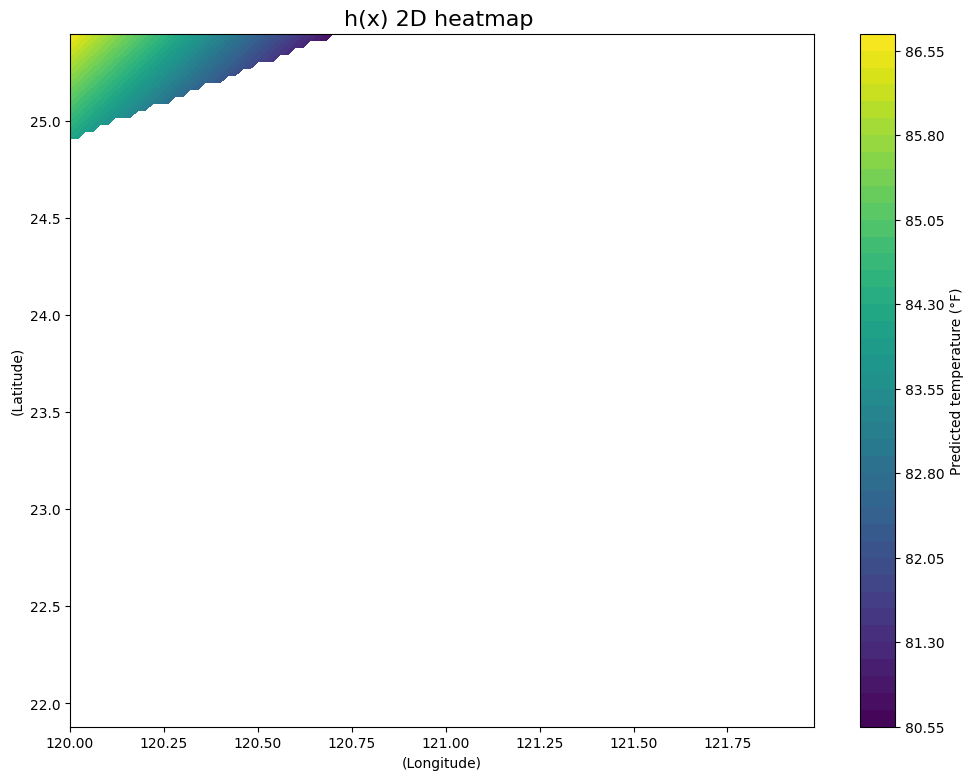

In [90]:
lon_min, lon_max = X_class[:, 0].min(), X_class[:, 0].max()
lat_min, lat_max = X_class[:, 1].min(), X_class[:, 1].max()
lon_grid, lat_grid = np.meshgrid(np.linspace(lon_min, lon_max, 100), np.linspace(lat_min, lat_max, 100))
grid_points = np.c_[lon_grid.ravel(), lat_grid.ravel()]
z_preds = h_model.predict(grid_points)
z_grid = z_preds.reshape(lon_grid.shape)

# 2D 熱圖
plt.figure(figsize=(12, 9)); z_masked = np.ma.masked_where(z_grid == -999.0, z_grid)
plt.contourf(lon_grid, lat_grid, z_masked, levels=50, cmap='viridis'); plt.colorbar(label='Predicted temperature (°F)')
plt.xlabel('(Longitude)'); plt.ylabel('(Latitude)'); plt.title('h(x) 2D heatmap ', fontsize=16); plt.show()

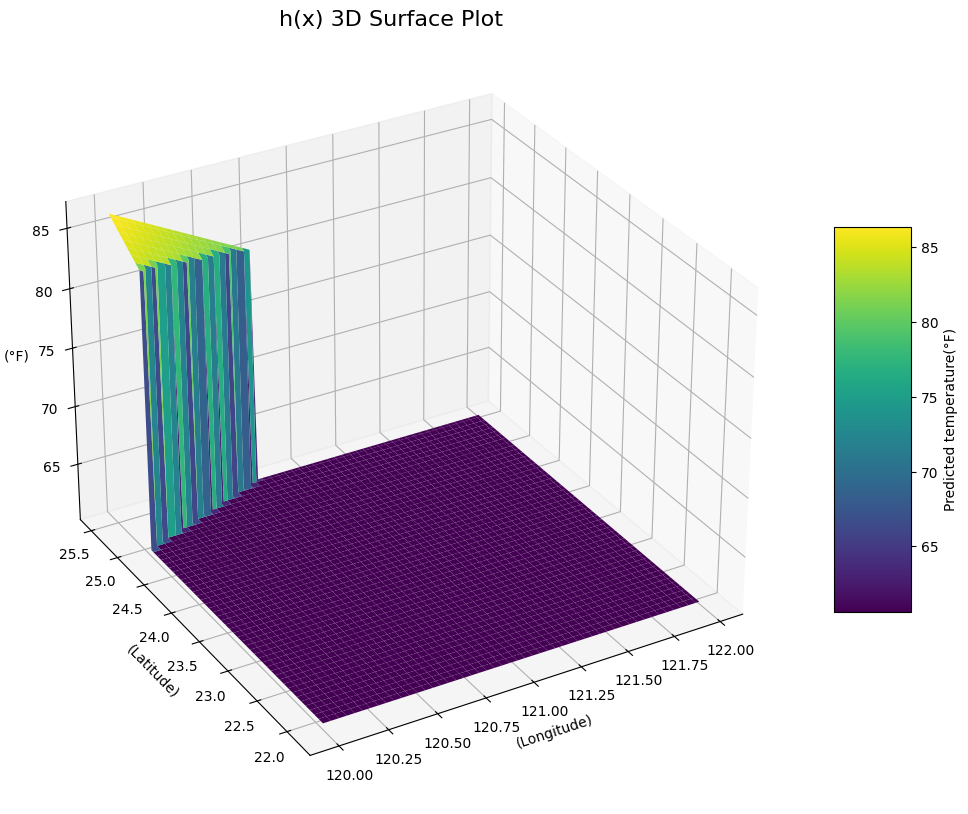

In [91]:
# 3D 曲面圖
fig = plt.figure(figsize=(14, 10)); ax = fig.add_subplot(111, projection='3d')
min_temp_for_plot = np.nanmin(z_masked) if not z_masked.mask.all() else 60
z_plot = np.copy(z_grid); z_plot[z_plot == -999] = min_temp_for_plot - 20
surf = ax.plot_surface(lon_grid, lat_grid, z_plot, cmap='viridis', edgecolor='none'); fig.colorbar(surf, shrink=0.5, aspect=5, label='Predicted temperature(°F)')
ax.set_xlabel('(Longitude)'); ax.set_ylabel('(Latitude)'); ax.set_zlabel('(°F)'); ax.set_title('h(x) 3D Surface Plot ', fontsize=16)
ax.view_init(elev=30, azim=-120); plt.show()